In [1]:
import os
os.chdir("..")
import sys
sys.path.append(os.getcwd())
print(os.getcwd())

/home/development/SPOT/backend-zoning


In [ ]:
# base python imports
import json

# third-party imports
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jeffutils.analytics import set_np_pd_display_params, movecol
from jeffutils.utils import reimport
set_np_pd_display_params(np, pd)

# native imports
# the reimport function helps reimport .py files without having to restart the python kernel
reimport("""
import modules.data_manager as dm
from modules.parking_zone_class import ParkingZone, get_parking_zone_from_zoneID
from modules.display import show_video
from tests.jfsb_selection_test import test_parking_zone_inference
""", globals())
import modules.data_manager as dm
from modules.parking_zone_class import ParkingZone, get_parking_zone_from_zoneID
from modules.display import show_video
from modules.spot_classes.car_class import Car
from tests.jfsb_selection_test import test_parking_zone_inference

In [ ]:
# when I recorded these videos, I had the center_west and center_east cameras swapped.
# this is the case for P3 center_west and center_east cameras as well
video_label = "2025-02-16-09-05-29_000004-1-JFSBP1_center_west"
zoneID = "JFSBP1_center_east-region_1-south_east"

parking_zone:ParkingZone = get_parking_zone_from_zoneID(zoneID)

# analyze the results

In [35]:
model_label = "256hist_center_kandzerocenters"
model_label = "8hist_center_kandzerocenters"
model_directory = f"tests/results/{model_label}/"
dfs = []
for directory in os.listdir(model_directory):
    zoneID = directory
    directory = os.path.join(model_directory, directory)
    df = pd.concat([
        pd.read_csv(os.path.join(directory, f))
        for f in os.listdir(directory)
        if f.endswith(".csv")
    ]).reset_index(drop=True)
    df["zoneID"] = zoneID
    dfs.append(df)
full_results_df = pd.concat(dfs).reset_index(drop=True)

In [36]:
def get_accuracy_table(cols:list[str]|str):
    acc_tab = (full_results_df
        .groupby(by=cols)
        ['is_match']
        .mean()
        .reset_index()
        .sort_values(by='is_match', ascending=False).
        rename(columns={'is_match': 'accuracy'}))
    return acc_tab

full_accuracy_table = get_accuracy_table(['zoneID', 'zone_size', 'k', 'pair_index'])
zoneID_accuracy_table = get_accuracy_table('zoneID')
zone_size_accuracy_table = get_accuracy_table('zone_size')
pair_index_accuracy_table = get_accuracy_table('pair_index')

zone_size_accuracy_table['random_acc'] = 1/zone_size_accuracy_table['zone_size']
zone_size_accuracy_table['better_than_random'] = zone_size_accuracy_table['accuracy'] > zone_size_accuracy_table['random_acc']
zone_size_accuracy_table['perc_better_than_random'] = (zone_size_accuracy_table['accuracy'] - zone_size_accuracy_table['random_acc']) / zone_size_accuracy_table['random_acc'] * 100
zone_size_accuracy_table['timesX_better_than_random'] = zone_size_accuracy_table['accuracy'] / zone_size_accuracy_table['random_acc']

display(full_accuracy_table)
display(zoneID_accuracy_table)
display(pair_index_accuracy_table)
display(zone_size_accuracy_table)

,zoneID,zone_size,k,pair_index,accuracy
140,JFSBP1_center_east-region_1-south_east,11,5,4,1.0000000
156,JFSBP1_center_east-region_1-south_east,11,7,4,1.0000000
69,JFSBP1_center_east-region_1-south_east,9,3,5,1.0000000
68,JFSBP1_center_east-region_1-south_east,9,3,4,1.0000000
164,JFSBP1_center_east-region_1-south_east,11,8,4,1.0000000
...,...,...,...,...,...
65,JFSBP1_center_east-region_1-south_east,9,3,1,0.0000000
170,JFSBP1_center_east-region_1-south_east,11,9,2,0.0000000
63,JFSBP1_center_east-region_1-south_east,7,7,7,0.0000000
174,JFSBP1_center_east-region_1-south_east,11,9,6,0.0000000


,zoneID,accuracy
0,JFSBP1_center_east-region_1-south_east,0.3565670


,pair_index,accuracy
5,5,1.0000000
4,4,0.7707432
3,3,0.6067637
1,1,0.3456547
0,0,0.1108926
2,2,0.0157295
7,7,0.0015729
6,6,0.0011797


,zone_size,accuracy,random_acc,better_than_random,perc_better_than_random,timesX_better_than_random
0,5,0.4433333,0.2000000,True,121.6666667,2.2166667
1,7,0.3815000,0.1428571,True,167.0500000,2.6705000
2,9,0.3487500,0.1111111,True,213.8750000,3.1387500
3,11,0.3262500,0.0909091,True,258.8750000,3.5887500
4,13,0.3164336,0.0769231,True,311.3636364,4.1136364


In [ ]:
zone_size_corr = full_accuracy_table['zone_size'].corr(full_accuracy_table['accuracy'])
print(f"Pearson correlation coefficient between 'zone_size' and 'accuracy': {zone_size_corr}")
k_corr = full_accuracy_table['k'].corr(full_accuracy_table['accuracy'])
print(f"Pearson correlation coefficient between 'k' and 'accuracy': {k_corr}")
overall_accuracy = full_results_df['is_match'].mean()
print(f"Overall accuracy: {overall_accuracy}")

Pearson correlation coefficient between 'zone_size' and 'accuracy': -0.07897021443042365
Pearson correlation coefficient between 'k' and 'accuracy': 0.06813149214183732
Overall accuracy: 0.35656704679512385


**Results Analysis:** 
  * It appears that as zone_size increases, there is a pattern for the accuracy to go down. 
  * It appears that there isn't much of a correlation between k and accuracy
  * overall accuracy is between 1.5-2 times better than random guessing

**Changes analysis:**
  * I changed the closest_k_points to always include the points that have a center of (0, 0) since this is what is returned by the get_center_pt function if the car didn't actually fully cross into the zone. This change increased the accuracy from ~18% to 35%
  * I changed the Histogram bin size to 8, and the accuracy stayed at 35%, but the zone_size and k correlation dropped to having NO correlation at all, which is a VERY big win

# runs and display tests

In [6]:
zone_sizes = list(range(5, 13+1, 2))

for zone_size in zone_sizes:
    for k in range(3, zone_size+1):
        print()
        print(f"zone_size: {zone_size}, k: {k}")
        print()
        results = test_parking_zone_inference(zone_size, zoneID, zoneID, k=k)
        results_df = pd.DataFrame(results)
        results_df['zone_size'] = zone_size
        results_df['k'] = k
        print(f"zone_size: {zone_size}, k: {k}, results: {results}")

results = test_parking_zone_inference(7, zoneID, zoneID, k=5)


zone_size: 5, k: 3



    1/100 tests for pair#0    :   0%|          | 0/8 [00:04<?, ?it/s]

TypeError: 'tuple' object does not support item assignment

In [4]:
from itertools import combinations

options = ['a', 'b', 'c', 'd', 'e']
zone_size = 3

for combo in list(combinations(options, zone_size)):
    print(combo)

('a', 'b', 'c')
('a', 'b', 'd')
('a', 'b', 'e')
('a', 'c', 'd')
('a', 'c', 'e')
('a', 'd', 'e')
('b', 'c', 'd')
('b', 'c', 'e')
('b', 'd', 'e')
('c', 'd', 'e')


In [21]:
results_df = pd.DataFrame(results)
display(results_df)

,pair_index,pair_enter_video,pair_leave_video,matched_car,enter_car,leave_car,is_match
0,0,2025-02-14-18-43-14_000004-1-JFSBP1_center_west,2025-02-14-23-55-13_000004-1-JFSBP1_center_west,"Car(carID='target',feature=[339.42169189453125...","Car(carID='target',feature=[339.42169189453125...","Car(carID='target',feature=[1695.07275390625, ...",True
1,0,2025-02-14-18-43-14_000004-1-JFSBP1_center_west,2025-02-14-23-55-13_000004-1-JFSBP1_center_west,"Car(carID='target',feature=[339.42169189453125...","Car(carID='target',feature=[339.42169189453125...","Car(carID='target',feature=[1695.07275390625, ...",True
2,0,2025-02-14-18-43-14_000004-1-JFSBP1_center_west,2025-02-14-23-55-13_000004-1-JFSBP1_center_west,"Car(carID='target',feature=[339.42169189453125...","Car(carID='target',feature=[339.42169189453125...","Car(carID='target',feature=[1695.07275390625, ...",True
3,0,2025-02-14-18-43-14_000004-1-JFSBP1_center_west,2025-02-14-23-55-13_000004-1-JFSBP1_center_west,"Car(carID='target',feature=[339.42169189453125...","Car(carID='target',feature=[339.42169189453125...","Car(carID='target',feature=[1695.07275390625, ...",True
4,0,2025-02-14-18-43-14_000004-1-JFSBP1_center_west,2025-02-14-23-55-13_000004-1-JFSBP1_center_west,"Car(carID='target',feature=[339.42169189453125...","Car(carID='target',feature=[339.42169189453125...","Car(carID='target',feature=[1695.07275390625, ...",True
...,...,...,...,...,...,...,...
395,7,2025-02-16-09-05-29_000004-1-JFSBP1_center_west,2025-02-16-11-01-30_000004-1-JFSBP1_center_west,"Car(carID='target',feature=[1041.591552734375,...","Car(carID='target',feature=[666.2535400390625,...","Car(carID='target',feature=[3556.179931640625,...",True
396,7,2025-02-16-09-05-29_000004-1-JFSBP1_center_west,2025-02-16-11-01-30_000004-1-JFSBP1_center_west,"Car(carID='target',feature=[1041.591552734375,...","Car(carID='target',feature=[666.2535400390625,...","Car(carID='target',feature=[3556.179931640625,...",True
397,7,2025-02-16-09-05-29_000004-1-JFSBP1_center_west,2025-02-16-11-01-30_000004-1-JFSBP1_center_west,Car(carID='76d3ac9c-bafe-4b36-bc01-91fc91c575c...,"Car(carID='target',feature=[666.2535400390625,...","Car(carID='target',feature=[3556.179931640625,...",False
398,7,2025-02-16-09-05-29_000004-1-JFSBP1_center_west,2025-02-16-11-01-30_000004-1-JFSBP1_center_west,Car(carID='8294d3a4-7781-4ade-84d0-7e8facb5bd7...,"Car(carID='target',feature=[666.2535400390625,...","Car(carID='target',feature=[3556.179931640625,...",False


In [31]:
display(results_df.groupby('pair_index')['is_match'].mean().reset_index().sort_values('pair_index', ascending=True))

,pair_index,is_match
0,0,1.0000000
1,1,0.0000000
2,2,0.0000000
3,3,0.0000000
4,4,0.5800000
5,5,0.5600000
6,6,0.4000000
7,7,0.4600000


# dev for tests/test_sets/JFSBP1_center_west-region_1-north_west.json test set

In [127]:
def load_test_set(label:str) -> list[dict]:
    with open(f"tests/test_sets/{label}.json", "r") as f:
        return json.load(f)
    
def get_enter_videos(test_set:list[dict]) -> list[str]:
    return [
        e['enter']
        for e in test_set
        if (
            e['leave'] is None and
            e['enter'] is not None
        )
    ]
    
def get_leave_videos(test_set:list[dict]) -> list[str]:
    return [
        e['leave']
        for e in test_set
        if (
            e['leave'] is not None and
            e['enter'] is not None
        )
    ]
    
def get_video_pairs(test_set:list[dict]) -> list[str]:
    return [
        (e['enter'], e['leave'])
        for e in test_set
        if (
            e['leave'] is not None and
            e['enter'] is not None
        )
    ]

test_set = load_test_set(zoneID)
enter_videos = get_enter_videos(test_set)
leave_videos = get_leave_videos(test_set)
pair_videos = get_video_pairs(test_set)

print("enter_videos")
_=[print(i) for i in enter_videos]
print("\nleave_videos")
_=[print(i) for i in leave_videos]
print("\npair_videos")
_=[print(i) for i in pair_videos]


enter_videos
2025-02-15-11-04-14_000004-1-JFSBP1_center_west
2025-02-15-19-55-56_000004-1-JFSBP1_center_west
2025-02-16-07-58-00_000004-1-JFSBP1_center_west
2025-02-16-08-54-43_000004-1-JFSBP1_center_west
2025-02-16-10-19-29_000004-1-JFSBP1_center_west
2025-02-16-10-42-30_000004-1-JFSBP1_center_west

leave_videos
2025-02-14-23-55-13_000004-1-JFSBP1_center_west
2025-02-15-15-19-11_000004-1-JFSBP1_center_west
2025-02-15-20-07-27_000004-1-JFSBP1_center_west
2025-02-16-11-01-30_000004-1-JFSBP1_center_west
2025-02-16-14-17-14_000004-1-JFSBP1_center_west
2025-02-16-14-28-13_000004-1-JFSBP1_center_west
2025-02-16-13-09-58_000004-1-JFSBP1_center_west
2025-02-17-08-28-13_000004-1-JFSBP1_center_west

pair_videos
('2025-02-14-18-43-14_000004-1-JFSBP1_center_west', '2025-02-14-23-55-13_000004-1-JFSBP1_center_west')
('2025-02-15-12-23-42_000004-1-JFSBP1_center_west', '2025-02-15-15-19-11_000004-1-JFSBP1_center_west')
('2025-02-15-14-27-43_000004-1-JFSBP1_center_west', '2025-02-15-20-07-27_000004-1-

In [88]:

frames, record = dm.load_frames_and_record(enter_videos[0])
if len(record['track_id'].unique()) > 1:
    raise ValueError("More than one track_id in enter video")

feature = parking_zone.create_feature(frames, record, 'enter')

car = Car()
car.set_feature(feature)


car_repr = repr(car)
print(car_repr)

car = Car.from_repr(car_repr)
print(car)

Car(carID='18508cce-1a74-440c-8855-c75f8ccec2a1',feature=[432.7450866699219, 0.0, 0.0, 82.66666412353516, 2.313725471496582, 273.0980529785156, 45.882354736328125, 4.941176414489746, 0.23529411852359772, 0.2549019753932953, 0.4313725531101227, 74.05882263183594, 1.1960784196853638, 0.019607843831181526, 3.5098040103912354, 38.70588302612305, 0.0, 2.901960849761963, 0.1568627506494522, 2.588235378265381, 132.39215087890625, 0.0, 2.588235378265381, 0.0, 0.0, 0.0, 69.96078491210938, 0.0, 0.0, 0.0, 508.0, 0.0, 0.0, 0.0, 37.80392074584961, 0.0, 0.0, 0.0, 1.6666666269302368, 0.7058823704719543, 6.117647171020508, 1.5882352590560913, 114.05882263183594, 0.0, 6.372549057006836, 0.2549019753932953, 21.54901885986328, 4.901960849761963, 0.0, 0.0, 121.5686264038086, 0.019607843831181526, 3.7647058963775635, 0.0784313753247261, 2.0784313678741455, 26.58823585510254, 0.0, 0.0, 0.0, 0.0, 23.294116973876953, 0.0, 0.0, 0.019607843831181526, 0.03921568766236305, 0.0, 58.39215850830078, 0.0, 0.039215687

In [89]:
# test to make sure the get_drive_pics function works
drive_pics = parking_zone.get_drive_pics(frames, record, frame_skip=5, track_id=1, track_id_col='track_id')

In [161]:
label = "2025-02-15-11-04-14_000004-1-JFSBP1_center_west"
label = "2025-02-16-12-02-27_000004-1-JFSBP1_center_west"
label = "2025-02-15-14-27-43_000004-1-JFSBP1_center_west"

frames, record = dm.load_frames_and_record(label)
record['in_driving_region'] = parking_zone.compute_in_driving_region(record)

curr_in_driving_region = (record['in_driving_region'].values).astype(bool)
next_in_driving_region = (record['in_driving_region'].shift(-1).values == True).astype(bool)

record['curr_in_driving_region'] = curr_in_driving_region
record['next_in_driving_region'] = next_in_driving_region

record = movecol(record, ['in_driving_region'], ref_col='next_in_driving_region', place='After')

display(record)

# test to make sure the get_center_pt with the which parameter works
enter_center_pt = parking_zone.get_center_pt(record, action='enter')
# leave_center_pt = parking_zone.get_center_pt(record, action='leave')

plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
plt.scatter(*enter_center_pt, color='red', s=20, label='enter')
# plt.scatter(*leave_center_pt, color='green', s=20, label='leave')
plt.show()

,track_id,track_uuid,velocity_x,velocity_y,is_moving,moving_count,moving_state,moving_state_count,not_moving_count,parked,age,confidence,hits,time_since_update,tl_x,tl_y,yolo_w,yolo_h,cx,cy,aspect_ratio,h,dcx,dcy,d_aspect_ratio,dh,iteration,confirmed,timestamp,w,record_num,no_update_or_no_confirmed,next_no_update_or_no_confirmed,std_more_than_dim,sufficient_total_distance,sufficient_num_moving,sufficient_hits,actually_moving,cx_ma,cy_ma,in_parking_region,which_passoff_region,in_any_passoff_region,br_x,br_y,iou,is_jump,track_id_jump,avg_h,avg_w,x_std,y_std,max_hits,min_x,max_x,min_y,max_y,abs_dx,abs_dy,num_moving,any_in_driving_region,any_in_parking_region,any_in_passoff_region,is_jump_track,spotID,vx,vy,vx_ma,vy_ma,direction,curr_in_driving_region,next_in_driving_region,in_driving_region
0,3,2852866e-b1fe-4397-80fc-cd64e7998d62,0.2066116,0.0000000,False,0,stationary,1,1,False,2,0.4353027,2,0,1342.0000000,6.0000000,91.0000000,65.0000000,1387.3677686,38.5000000,1.3190787,64.7355372,0.2066116,0.0000000,0.0000000,0.4132231,2,True,1739629663.2112677,85.3912711,1,False,False,True,True,True,True,True,1387.3677686,38.5000000,False,JFSBP1_center_west-region_4,True,1427.3912711,70.7355372,NaN,False,-30,117.1729911,173.4646230,113.9666659,39.8958785,36,1311.6867620,1722.0271620,35.9899402,167.5379638,410.3404000,131.5480236,33,True,False,True,True,NaN,2.5139624,0.6315869,2.5139624,0.6315869,"RIGHT,DOWN",True,True,True
1,3,2852866e-b1fe-4397-80fc-cd64e7998d62,0.1832851,0.0000000,False,0,stationary,2,2,False,3,0.4096680,3,0,1343.0000000,6.0000000,89.0000000,65.0000000,1387.5170632,38.5000000,1.3205209,65.0341264,0.1832851,0.0000000,0.0000000,0.3665702,3,True,1739629663.4225352,85.8789257,1,False,False,True,True,True,True,True,1387.4424159,38.5000000,False,JFSBP1_center_west-region_4,True,1428.8789257,71.0341264,0.9669577,False,-30,117.1729911,173.4646230,113.9666659,39.8958785,36,1311.6867620,1722.0271620,35.9899402,167.5379638,410.3404000,131.5480236,33,True,False,True,True,NaN,0.0746473,0.0000000,1.2943048,0.3157935,"RIGHT,DOWN",True,True,True
2,3,2852866e-b1fe-4397-80fc-cd64e7998d62,-2.3199055,-0.6451291,True,1,stationary,3,1,False,4,0.3332520,4,0,1331.0000000,5.0000000,94.0000000,62.0000000,1380.3484126,36.6052393,1.3278192,62.8232940,-2.3199055,-0.6451291,0.0000000,-0.5109851,4,True,1739629663.6338029,83.4179750,1,False,False,True,True,True,True,True,1385.0777481,37.8684131,False,JFSBP1_center_west-region_4,True,1414.4179750,67.8232940,0.6887750,False,-30,117.1729911,173.4646230,113.9666659,39.8958785,36,1311.6867620,1722.0271620,35.9899402,167.5379638,410.3404000,131.5480236,33,True,False,True,True,NaN,-2.3646678,-0.6315869,0.0746473,0.0000000,"RIGHT,DOWN",True,True,True
3,3,2852866e-b1fe-4397-80fc-cd64e7998d62,-2.3258701,-0.6367829,True,2,moving,1,0,False,5,0.3784180,5,0,1331.0000000,5.0000000,94.0000000,62.0000000,1378.0071892,35.9899402,1.3363258,62.0787608,-2.3258701,-0.6367829,0.0000000,-0.5763295,5,True,1739629663.8450704,82.9574504,1,False,False,True,True,True,True,True,1383.3101084,37.3987949,False,JFSBP1_center_west-region_4,True,1413.9574504,67.0787608,0.9826935,False,-30,117.1729911,173.4646230,113.9666659,39.8958785,36,1311.6867620,1722.0271620,35.9899402,167.5379638,410.3404000,131.5480236,33,True,False,True,True,NaN,-1.7676397,-0.4696182,-1.3525534,-0.3670684,"LEFT,UP",True,True,True
4,3,2852866e-b1fe-4397-80fc-cd64e7998d62,-2.2718387,0.5749422,True,3,moving,2,0,False,6,0.4648438,6,0,1333.0000000,10.0000000,86.0000000,65.0000000,1375.9118200,40.5224462,1.3356331,64.0322117,-2.2718387,0.5749422,0.0000000,0.0166725,6,True,1739629664.0563381,85.5235397,1,False,False,True,True,True,True,True,1381.8304507,38.0235251,False,JFSBP1_center_west-region_4,True,1418.5235397,74.0322117,0.7694908,False,-30,117.1729911,173.4646230,113.9666659,39.8958785,36,1311.6867620,1722.0271620,35.9899402,167.5379638,410.3404000,131.5480236,33,True,False,True,True,NaN,-1.4796577,0.6247303,-1.8706551,-0.1588250,"LEFT,UP",True,True,True
5,3,2852866e

ValueError: Could not find enter point

# show video

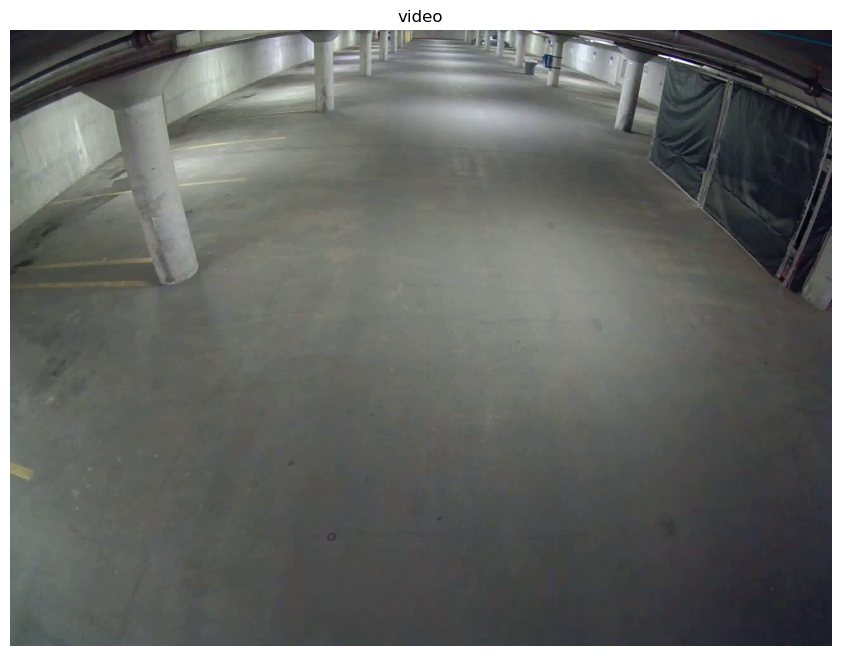

In [122]:
label = "2025-02-16-09-05-29_000004-1-JFSBP1_center_west"
label = leave_videos[0]
frames, record = dm.load_frames_and_record(label)
show_video(frames, record)

# ParkingZone.compute_in_driving_region

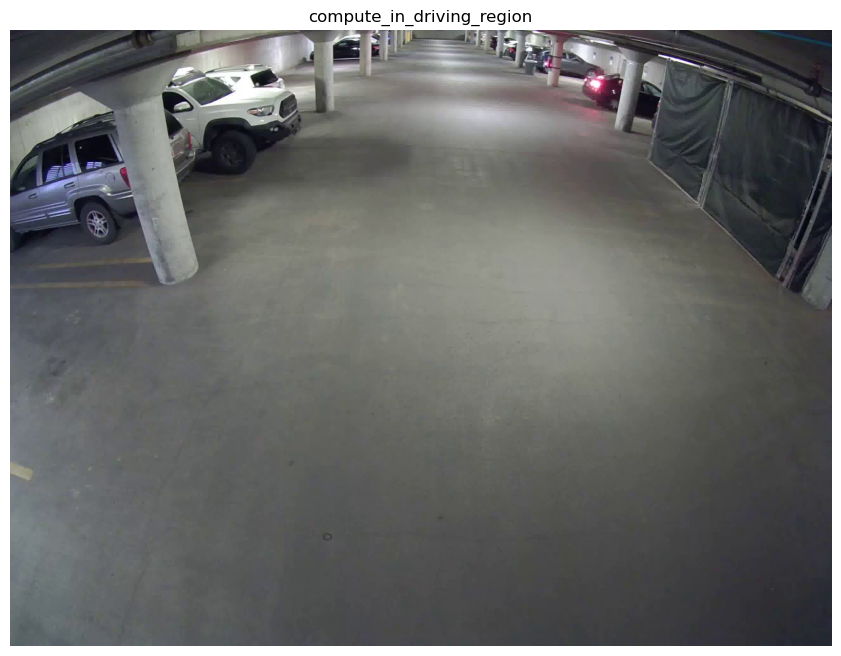

In [13]:
from IPython.display import clear_output

label = "2025-02-16-09-05-29_000004-1-JFSBP1_center_west"
# label = leave_videos[0]
label = "2025-02-16-12-02-27_000004-1-JFSBP1_center_west"
label = "2025-02-15-14-27-43_000004-1-JFSBP1_center_west"
label = "2025-02-15-15-19-11_000004-1-JFSBP1_center_west"
label = "2025-02-16-11-52-44_000004-1-JFSBP1_center_west"
frames, record = dm.load_frames_and_record(label)

record['in_driving_region'] = parking_zone.compute_in_driving_region(record)

# load the bounding boxes for the relevant tracks and map them to each frame
track_id_col = 'track_id'
plt_show = True
title_string = "compute_in_driving_region"
SPOT_YELLOW_BGR = (116, 227, 255)


frame_tracks = {}
record['br_x'] = record['tl_x'] + record['w']
record['br_y'] = record['tl_y'] + record['h']
for iteration, frame in record.groupby('iteration'):
    frame = frame.loc[frame['confirmed'], :]
    bbox_df = frame[[track_id_col, 'confidence', 'in_driving_region', 'tl_x', 'tl_y', 'br_x', 'br_y']]
    bbox_arr = bbox_df.to_numpy().astype(float)
    frame_tracks[int(iteration)-1] = bbox_arr
    
# loop through the frames and draw the bounding boxes on each frame
for i, frame in enumerate(frames):
    disp_frame = frame.copy()
    bbox = frame_tracks.get(i, None)
    if bbox is not None:
        for track_id, confidence, in_driv_reg_comp, tl_x, tl_y, br_x, br_y in bbox:
            color = SPOT_YELLOW_BGR if in_driv_reg_comp else (0, 0, 255)
            cv2.rectangle(disp_frame, (int(tl_x), int(tl_y)), (int(br_x), int(br_y)), color, 5)
            cv2.putText(disp_frame, f"{track_id}", (int(tl_x), int(tl_y)-10), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 2)
    
    # show the video via matplotlib or cv2
    if plt_show:
        plt.title(title_string) if title_string is not None else None
        disp_frame = cv2.cvtColor(disp_frame, cv2.COLOR_BGR2RGB)
        plt.imshow(disp_frame)
        plt.axis('off')
        plt.gcf().set_size_inches(15, 8)
        plt.show()
        clear_output(wait=True)  # Clear the previous frame
    else:
        cv2.imshow(title_string, disp_frame)
        if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty(title_string, cv2.WND_PROP_VISIBLE) < 1:
            break


# display the parking zone

In [ ]:
img = cv2.imread(dm.get)

# load an example of each datapoint for a specific video_name

In [14]:
video_name = "2025-02-14-17-25-00_000004-1-JFSBP1_center_east"
date_str, cam_label = dm.get_date_str_cam_label(video_name)
print(date_str, cam_label)

tracking_csv_path = dm.get_jfsb_tracking_csv_path(video_name)
tracking_df = pd.read_csv(tracking_csv_path)

motion_csv_path = dm.get_jfsb_motion_csv_path(video_name)
motion_df = pd.read_csv(motion_csv_path)

info_csv_path = dm.get_jfsb_info_csv_path()
info_df = pd.read_csv(info_csv_path)

video_path = dm.get_jfsb_video_path(video_name)

2025-02-14-17-25-00 000004-1-JFSBP1_center_east


# display number of enter/exit videos per region

In [15]:
for action, action_frame in info_df.groupby('which_action'):
    print(action)
    display(action_frame['which_parking_zone'].value_counts())

enter


which_parking_zone
JFSBP1_center_west-region_1-north_west    51
JFSBP2_east_west-region_0-south_east      32
JFSBP2_west_east-region_3-south_west      26
JFSBP1_east_west-region_0-south_east      19
JFSBP2_center_west-region_0-south_west    19
JFSBP2_center_east-region_0-north_east    18
JFSBP1_center_east-region_0-north_east    16
JFSBP2_center_east-region_1-south_east    16
JFSBP2_east_west-region_1-north_east      10
JFSBP1_center_east-region_1-south_east     9
JFSBP2_west_east-region_0-north_west       8
JFSBP1_east_west-region_1-north_east       7
JFSBP1_west_east-region_1-south_west       7
JFSBP1_center_west-region_0-south_west     5
JFSBP1_west_east-region_0-north_west       4
JFSBP2_center_west-region_1-north_west     3
Name: count, dtype: int64

exit


which_parking_zone
JFSBP2_center_east-region_0-north_east    22
JFSBP2_east_west-region_0-south_east      21
JFSBP2_west_east-region_3-south_west      21
JFSBP1_east_west-region_0-south_east      19
JFSBP1_center_east-region_0-north_east    16
JFSBP1_east_west-region_1-north_east      11
JFSBP1_center_west-region_1-north_west    10
JFSBP2_center_east-region_1-south_east     9
JFSBP2_east_west-region_1-north_east       9
JFSBP1_west_east-region_1-south_west       8
JFSBP2_center_west-region_0-south_west     8
JFSBP2_center_west-region_1-north_west     5
JFSBP2_west_east-region_0-north_west       3
JFSBP1_center_east-region_1-south_east     2
JFSBP1_center_west-region_0-south_west     2
JFSBP1_west_east-region_0-north_west       1
Name: count, dtype: int64

# test the data_manager methods

In [11]:
zoneID = "JFSBP1_center_west-region_0-south_west"

cam_label, region_id, zone_name = dm.parse_zoneID(zoneID)
print(cam_label, region_id, zone_name)

zone_settings = dm.get_zone_settings(zoneID)
print(json.dumps(zone_settings, indent=2))

cam_resolution = dm.get_camera_resolution(cam_label)
print(json.dumps(cam_resolution, indent=2))

# settings = dm.get_settings(cam_label)
# print(json.dumps(settings, indent=2))

000004-1-JFSBP1_center_west region_0 south_west
{
  "zone_name": "south_west",
  "direction": "LEFT",
  "points": [
    [
      0.0,
      0.0
    ],
    [
      0.46836,
      0.0
    ],
    [
      0.46759,
      0.02675
    ],
    [
      0.37269,
      0.09053
    ],
    [
      0.29282,
      0.16307
    ],
    [
      0.08063,
      0.40484
    ],
    [
      0.0,
      0.53447
    ]
  ]
}
{
  "height": 1944,
  "width": 2592
}


# display all of the 'JFSBP1_center_west-region_1-north_west' videos

In [18]:
import subprocess

In [19]:
already_seens = set()

In [22]:
zoneID = "JFSBP1_center_west-region_1-north_west"

info_df_filtered = info_df[info_df['which_parking_zone'] == zoneID].copy()
video_paths = info_df_filtered['video_path'].values
to_see_vids = [v for v in video_paths if v not in already_seens]

for video_path in to_see_vids:
    
    print(video_path)
    print()
    
    while True:
        subprocess.run(["mpv", video_path], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        response = input("Watch again [y/n]? ").strip().lower()
        if 'y' in response:
            continue
        else:
            break
        
    already_seens.add(video_path)


/home/development/DATA/desktop/ffmpeg_recordings/2025-02-14-18-25-59_000004-1-JFSBP1_center_west.mp4

/home/development/DATA/desktop/ffmpeg_recordings/2025-02-14-18-42-59_000004-1-JFSBP1_center_west.mp4

/home/development/DATA/desktop/ffmpeg_recordings/2025-02-14-18-43-14_000004-1-JFSBP1_center_west.mp4

/home/development/DATA/desktop/ffmpeg_recordings/2025-02-14-18-59-30_000004-1-JFSBP1_center_west.mp4

/home/development/DATA/desktop/ffmpeg_recordings/2025-02-14-23-55-13_000004-1-JFSBP1_center_west.mp4

/home/development/DATA/desktop/ffmpeg_recordings/2025-02-15-05-22-44_000004-1-JFSBP1_center_west.mp4

/home/development/DATA/desktop/ffmpeg_recordings/2025-02-15-09-56-27_000004-1-JFSBP1_center_west.mp4

/home/development/DATA/desktop/ffmpeg_recordings/2025-02-15-11-04-14_000004-1-JFSBP1_center_west.mp4

/home/development/DATA/desktop/ffmpeg_recordings/2025-02-15-11-08-14_000004-1-JFSBP1_center_west.mp4

/home/development/DATA/desktop/ffmpeg_recordings/2025-02-15-12-10-42_000004-1-JFSB